## Embeddings Demo

In [1]:
import openai
import umap
import json
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import util
import os

2022-08-11 11:15:45.054167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 11:15:45.054285: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Configuration

In [2]:
openai.api_key = os.getenv('OpenAI_API_Key')

In [3]:
courses = ['18.01', '18.02', '18.03', '6.042', '18.05', '18.06', 'COMS3251']
MATH_sections = ['MATH_Algebra', 'MATH_Counting_&_Probability', 'MATH_Intermediate_Algebra', 
                 'MATH_Number_Theory', 'MATH_Prealgebra', 'MATH_Precalculus']
image_labels = {'18.01':'r.', '18.02':'g.', '18.03':'b.', '18.05':'mx', '18.06':'k+', '6.042':'cx', 'COMS3251':'y+'}
courses_embeddings_location = './../code/course_embeddings.json'
MATH_embeddings_location = './../code/MATH_embeddings.json'
image_location = "UMAP.png"
embedding_engine = 'text-similarity-babbage-001'
questions_per_course = 25
questions_per_MATH_section = 15

### Helper Functions

In [4]:
def make_embeddings(embedding_engine, embeddings_location, courses, questions_per_course):
    """
    Takes json files of questions using our json file formatting, 
        embeds them using OpenAI's embedding_engine,
        and saves a new json, embeddings.json, of the embeddings.
    """
    list_of_embeddings = []
    for course in courses:
        print("Currently embedding " + course + "...")

        for num in range(1, questions_per_course + 1):
            if num < 10:
                q_num = '0' + str(num)
            else:
                q_num = str(num)
            json_location = './../data/' + course.split('_')[0] + '/' + course + '_Question_' + q_num + '.json'
            with open(json_location, 'r') as f:
                data = json.load(f)
            raw_question = data['Original question']
            embedding = openai.Embedding.create(input = raw_question, 
                                                engine = embedding_engine)['data'][0]['embedding']
            list_of_embeddings.append(embedding)

    embeddings = {'list_of_embeddings':list_of_embeddings}
    with open(embeddings_location, 'w') as f:
        f.write(json.dumps(embeddings))

def get_embeddings(embeddings_file):
    """
    Retrieves embeddings from embeddings_file. Embeddings are assumed to be (n x d).
    """
    with open(embeddings_file, 'r') as f:
        points = json.load(f)['list_of_embeddings']
    return np.array(points)

def get_most_similar(embeddings, i):
    """
    Returns most similar questions, while they are in their embedded form, 
        to the target, index i, via cosine similarity.
    """
    cos_sims = []
    cos_to_num = {}
    for j in range(len(embeddings)):
        cos_sim = util.cos_sim(embeddings[i], embeddings[j]).item()
        cos_to_num[cos_sim] = j
        cos_sims.append(cos_sim)
    ordered = sorted(cos_sims, reverse=True)
    closest_qs = []
    for val in ordered:
        closest_qs.append(cos_to_num[val]+1)
    return closest_qs[1:]

def reduce_via_umap(embeddings, num_dims=2):
    """
    Reduces the dimensionality of the provided embeddings(which are vectors) to num_dims via UMAP.
    If embeddings was an (n x d) numpy array, it will be reduced to a (n x num_dims) numpy array.
    """
    reducer = umap.UMAP(n_components=num_dims)
    reduced = reducer.fit_transform(embeddings)
    return reduced

def plot_clusters(points, image_loc, questions_per_course=25, show=False, question_labels=False, 
                  label_font='xx-small', dpi=200, width=9.5, height=6.5, legend_loc=(1, 1.01), right_shift=0.72):
    """
    Plots clusters of points. points is assumed to be a n by 2 numpy array.
    Set question_labels to True if you want to see each point labeled with its question number.
    Set show to True if you want the created plot to pop up.
    The other parameters are defaulted to values that we have found to work well for the visual itself.
    """
    x = [x for x,y in points]
    y = [y for x,y in points]
    plt.subplots_adjust(right=right_shift)
    figure = plt.gcf()
    figure.set_size_inches(w=width,h=height)

    for i, course in enumerate(courses):
        plt.scatter(x[i*questions_per_course:(i+1)*questions_per_course], 
                    y[i*questions_per_course:(i+1)*questions_per_course], 
                    c = image_labels[course][0], 
                    label = course, 
                    marker = image_labels[course][1])
        if question_labels:
            for j in range(questions_per_course):
                plt.annotate(j+1, (x[questions_per_course*i+j], y[questions_per_course*i+j]), fontsize=label_font)

    plt.legend(bbox_to_anchor=legend_loc)
    plt.savefig(image_loc, dpi=dpi)
    if show:
        plt.show()

## Generate and visualize embeddings

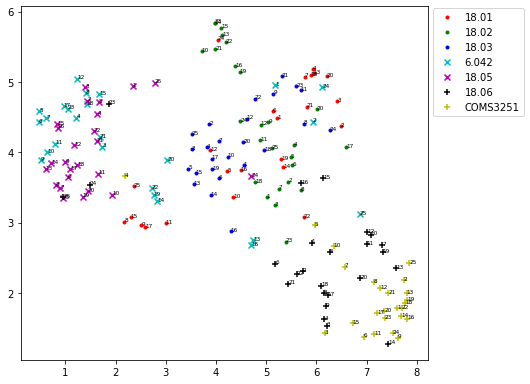

In [5]:
if not os.path.exists(courses_embeddings_location):
    make_embeddings(embedding_engine, courses_embeddings_location, courses, questions_per_course)
embeddings = get_embeddings(courses_embeddings_location)
reduced_points = reduce_via_umap(embeddings)
plot_clusters(reduced_points, image_location, questions_per_course=questions_per_course, question_labels=True)

#for MATH:
if not os.path.exists(MATH_embeddings_location):
    make_embeddings(embedding_engine, MATH_embeddings_location, MATH_sections, questions_per_MATH_section)